#### Treatment Comparison
Compare barcoded subpopulations of idling and untreated (control) SKMEL5 cells by their cell-cell distance


In [112]:
# load files and packages
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline


In [135]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 31.4 s, sys: 5.21 s, total: 36.6 s
Wall time: 37.8 s


In [8]:
top12 = range(1,13)

Using top barcodes in __Untreated__ set, look at abundance in __Idling__ set

In [9]:
min(U.barcode_counts(IDs=U.top_barcodes(top12)))

48

In [10]:
min(I.barcode_counts(IDs=U.top_barcodes(top12)))

36

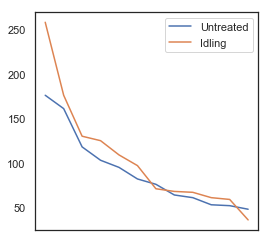

In [11]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top12)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top12)).plot(label='Idling', legend=True)
plt.show()

In [12]:
# get list of codes to use throughout the rest of analysis
selected_codes = U.top_barcodes(top12)

---
### PCA
100 component on arcsinh-transformed counts data

Perform PCA on each dataset and plot selected barcodes

In [13]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 14.3 s, sys: 2.17 s, total: 16.5 s
Wall time: 11.2 s


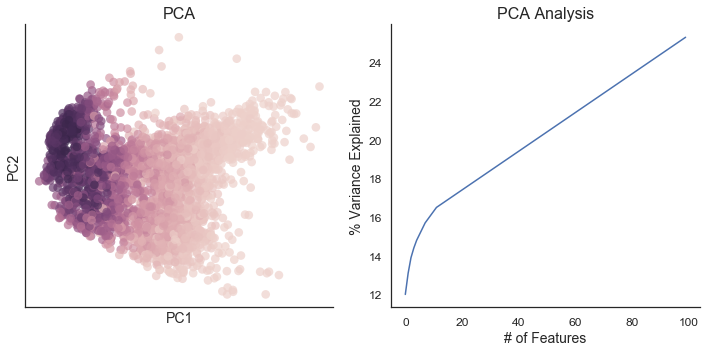

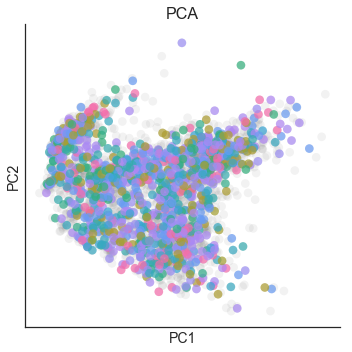

In [14]:
U_PCA.plot()
U_PCA.plot_barcodes(ranks=selected_codes)

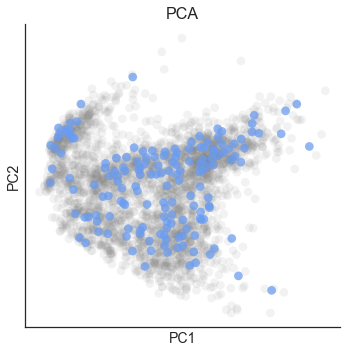

In [18]:
U_PCA.plot_barcodes(ranks=[selected_codes[1]])

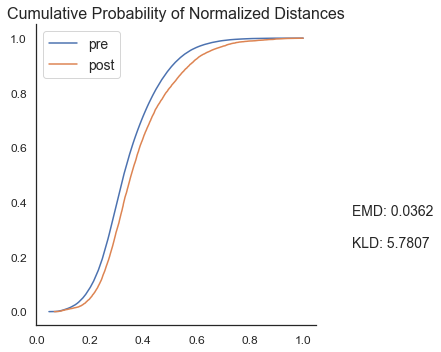

(0.03620713480495485, 5.780742939813468)

In [15]:
compare_distance_dist(pre=U_PCA.distance_matrix(ranks='all'), post=U_PCA.distance_matrix(ranks=[selected_codes[1]]))

In [16]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 18.6 s, sys: 3.98 s, total: 22.6 s
Wall time: 16.7 s


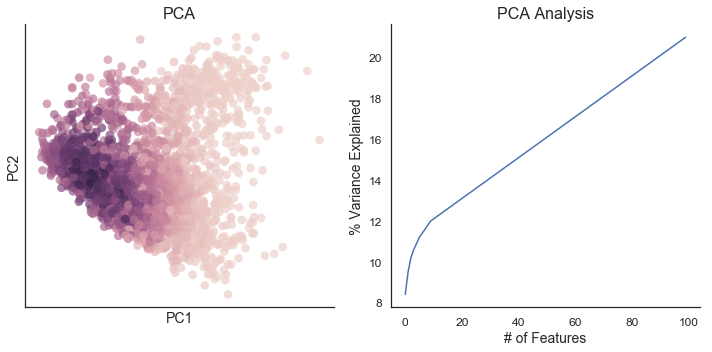

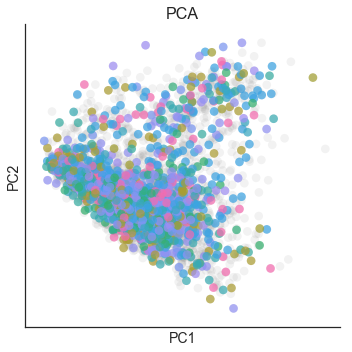

In [19]:
I_PCA.plot()
I_PCA.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

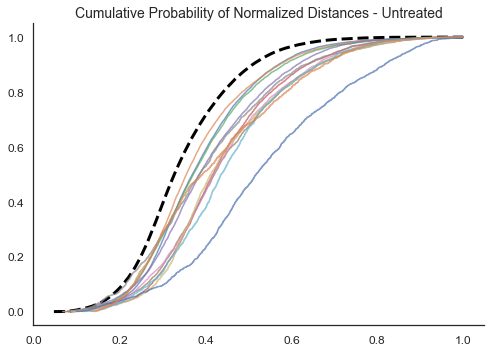

CPU times: user 20.6 s, sys: 1.46 s, total: 22 s
Wall time: 22 s


In [22]:
%%time
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

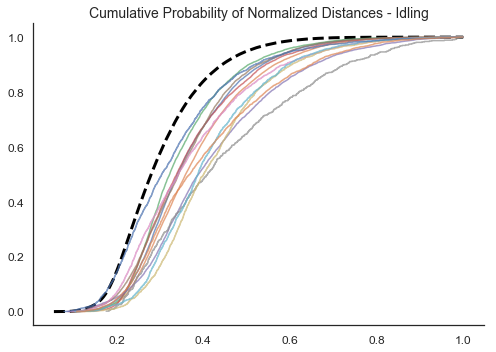

CPU times: user 30.6 s, sys: 1.2 s, total: 31.8 s
Wall time: 31.7 s


In [23]:
%%time
pre = I_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram(pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum(pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

---
Now, we want to generate statistical confidence in the "noise" or tolerance for EMD using random subsampling for calculation of EMD from the null population.

Need to correct for number of cells in each barcode, and bias in EMD compared to whole population. The acceptance criteria line should be fit to number of cells and have some growing uncertainty around it.

In [24]:
U.barcode_counts(selected_codes)

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA     95
CTGAGAGACTCTGTGACTGA     82
CTGAGACTCAGACAGACACT     76
CTGACTGTCAGACAGAGTGA     64
CTGAGTCAGTCACACTCTGT     61
CTGACTGTCTGTCAGTGTGT     53
CTGACAGTGTGTCAGTCTCT     52
CTGAGAGTCACTGAGTGTGT     48
Name: Barcode, dtype: int64

In [25]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,21):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_PCA.results[np.random.choice(U_PCA.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

CPU times: user 7min 2s, sys: 13.8 s, total: 7min 16s
Wall time: 7min 20s


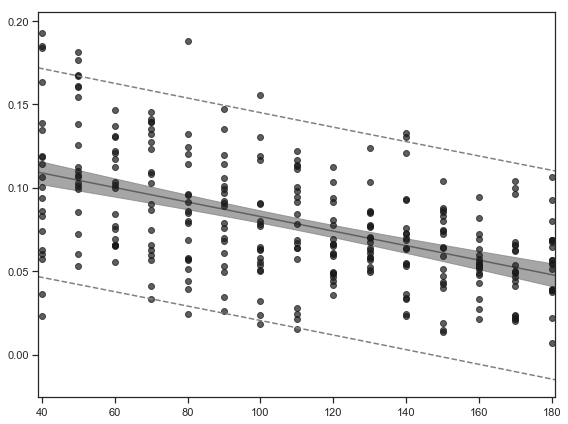

In [136]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=1)

---
Do the same as above for __Idling__ dataset

In [129]:
I.barcode_counts(selected_codes)

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
CTGACAGTGTCACACAGTGA    109
CTGAGAGACTCTGTGACTGA    97 
CTGAGAGTCACTGAGTGTGT    71 
CTGAGTCAGTCACACTCTGT    68 
CTGAGACTCAGACAGACACT    67 
CTGACAGTGTGTCAGTCTCT    61 
CTGACTGTCTGTCAGTGTGT    59 
CTGACTGTCAGACAGAGTGA    36 
Name: Barcode, dtype: int64

In [131]:
%%time 
# range of top 12 barcodes in idling dataset is 30 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = I_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

I_baseline_curve = []
for rep in np.arange(1,11):
    I_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(30, 261, 10):
        I_rand = I_PCA.results[np.random.choice(I_PCA.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(I_rand, I_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        I_EMD.append(EMD)
    
    if len(I_baseline_curve)==0:
        I_baseline_curve = pd.DataFrame({'n_cells':np.arange(30, 261, 10), 'EMD1':I_EMD})
        
    else:
        I_baseline_curve['EMD{}'.format(rep)] = I_EMD

CPU times: user 8min 47s, sys: 16.9 s, total: 9min 4s
Wall time: 9min 11s


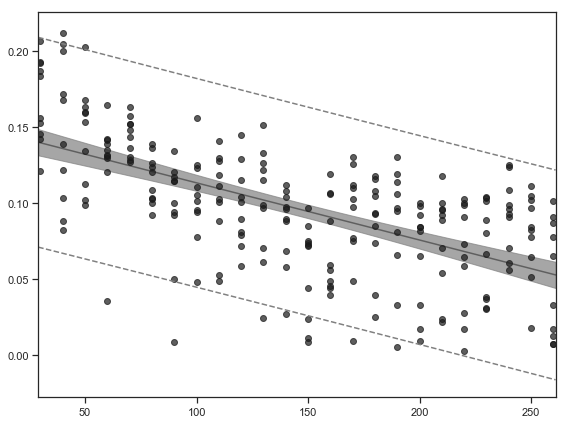

In [137]:
I_p, I_pi, I_ci = easy_regression(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'], deg=1)

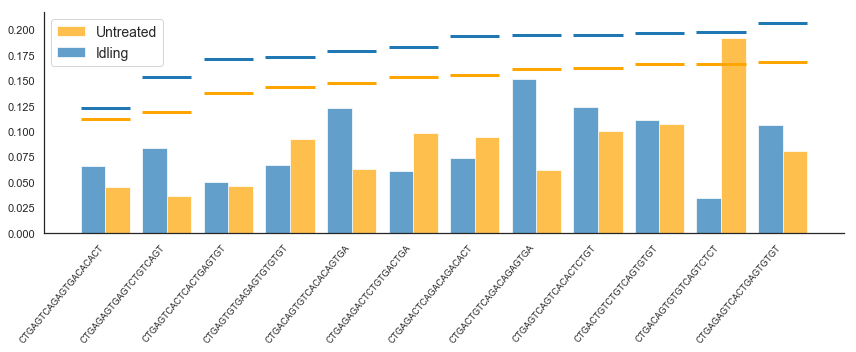

In [152]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()


Look at 11th barcode - switch to significance in idling

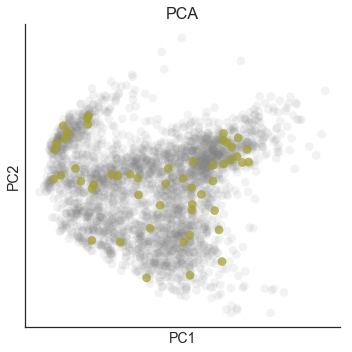

In [153]:
U_PCA.plot_barcodes(ranks=[selected_codes[10]])

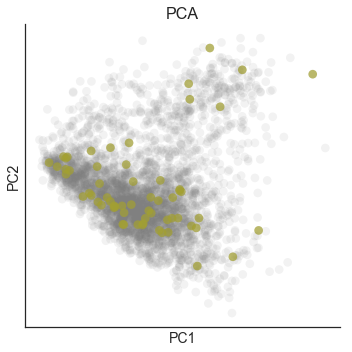

In [154]:
I_PCA.plot_barcodes(ranks=[selected_codes[10]])

Look at 8th barcode - significance in untreated control

---
### t-SNE
Primed with 100-component PCA. FIt-SNE implementation.

In [155]:
%time U_FItSNE = fcc_FItSNE(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 

CPU times: user 466 ms, sys: 46.3 ms, total: 513 ms
Wall time: 23.3 s


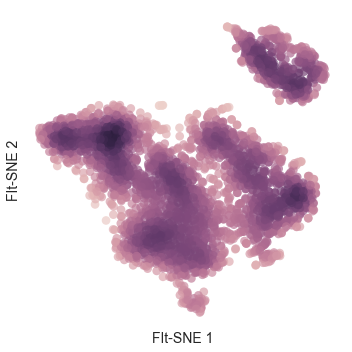

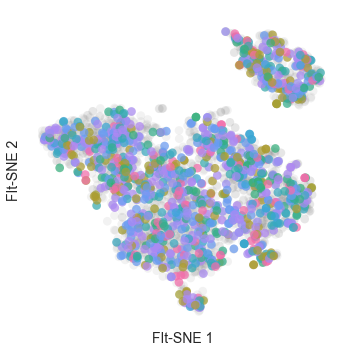

In [156]:
U_FItSNE.plot()
U_FItSNE.plot_barcodes(ranks=selected_codes)

In [157]:
%time I_FItSNE = fcc_FItSNE(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 

CPU times: user 711 ms, sys: 63.3 ms, total: 774 ms
Wall time: 29.1 s


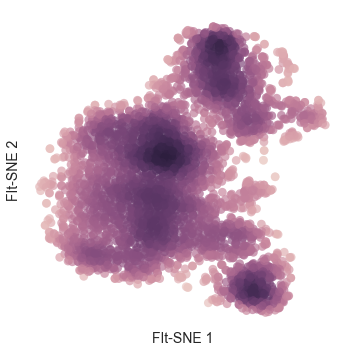

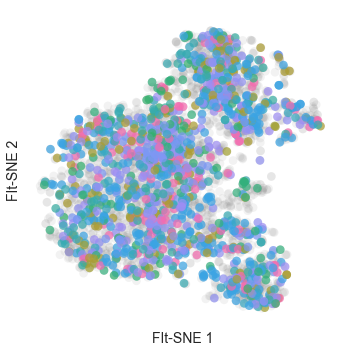

In [158]:
I_FItSNE.plot()
I_FItSNE.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

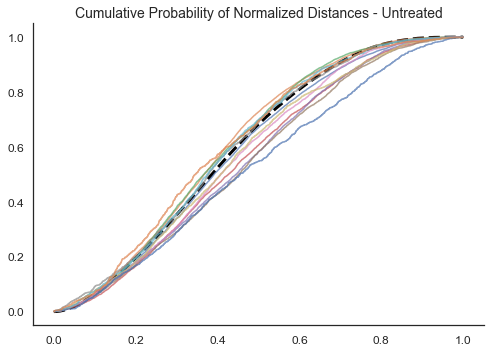

CPU times: user 18.5 s, sys: 687 ms, total: 19.1 s
Wall time: 19 s


In [159]:
%%time
pre = U_FItSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_FItSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

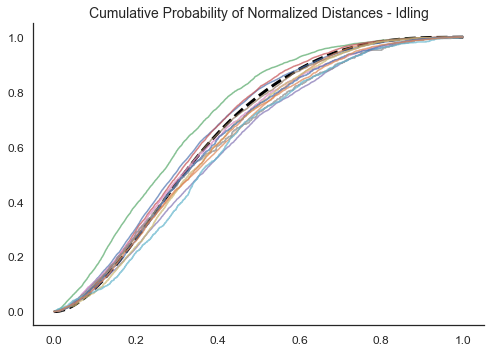

CPU times: user 28.2 s, sys: 1.1 s, total: 29.3 s
Wall time: 29.2 s


In [160]:
%%time
pre = I_FItSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram(pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum(pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_FItSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

---
Now, we want to generate statistical confidence in the "noise" or tolerance for EMD using random subsampling for calculation of EMD from the null population.

Need to correct for number of cells in each barcode, and bias in EMD compared to whole population. The acceptance criteria line should be fit to number of cells and have some growing uncertainty around it.

In [161]:
U.barcode_counts(selected_codes)

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA    95 
CTGAGAGACTCTGTGACTGA    82 
CTGAGACTCAGACAGACACT    76 
CTGACTGTCAGACAGAGTGA    64 
CTGAGTCAGTCACACTCTGT    61 
CTGACTGTCTGTCAGTGTGT    53 
CTGACAGTGTGTCAGTCTCT    52 
CTGAGAGTCACTGAGTGTGT    48 
Name: Barcode, dtype: int64

In [162]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_FItSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_FItSNE.results[np.random.choice(U_FItSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

CPU times: user 3min 34s, sys: 5.97 s, total: 3min 40s
Wall time: 3min 44s


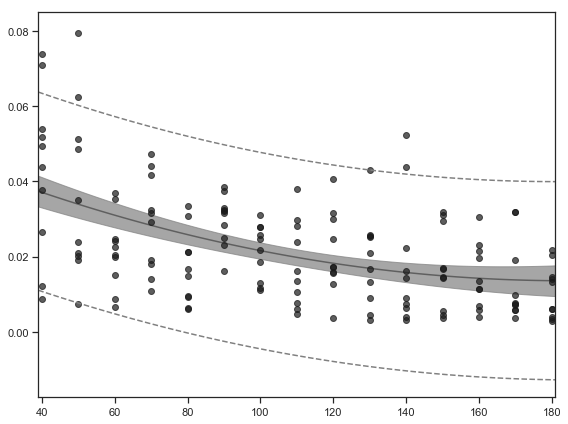

In [174]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

---
Do the same as above for __Idling__ dataset

In [164]:
I.barcode_counts(selected_codes)

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
CTGACAGTGTCACACAGTGA    109
CTGAGAGACTCTGTGACTGA    97 
CTGAGAGTCACTGAGTGTGT    71 
CTGAGTCAGTCACACTCTGT    68 
CTGAGACTCAGACAGACACT    67 
CTGACAGTGTGTCAGTCTCT    61 
CTGACTGTCTGTCAGTGTGT    59 
CTGACTGTCAGACAGAGTGA    36 
Name: Barcode, dtype: int64

In [165]:
%%time 
# range of top 12 barcodes in idling dataset is 30 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = I_FItSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

I_baseline_curve = []
for rep in np.arange(1,11):
    I_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(30, 261, 10):
        I_rand = I_FItSNE.results[np.random.choice(I_FItSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(I_rand, I_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        I_EMD.append(EMD)
    
    if len(I_baseline_curve)==0:
        I_baseline_curve = pd.DataFrame({'n_cells':np.arange(30, 261, 10), 'EMD1':I_EMD})
        
    else:
        I_baseline_curve['EMD{}'.format(rep)] = I_EMD

CPU times: user 8min 44s, sys: 12.7 s, total: 8min 57s
Wall time: 8min 58s


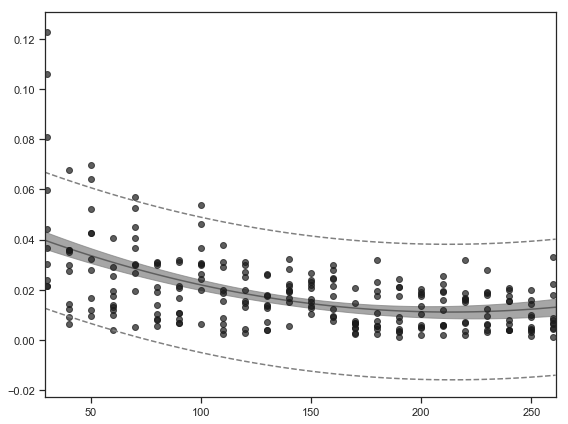

In [172]:
I_p, I_pi, I_ci = easy_regression(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

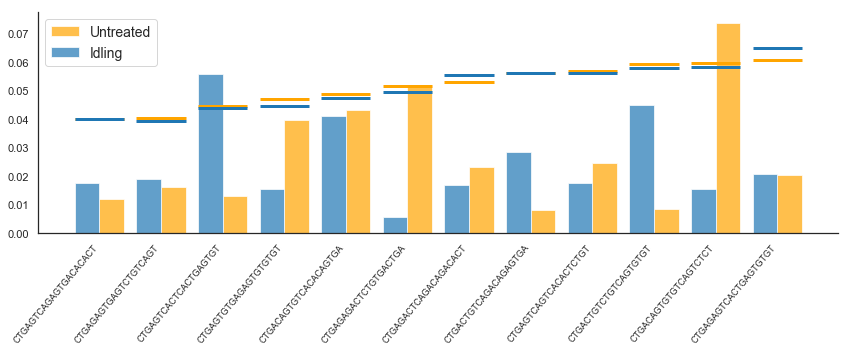

In [175]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()


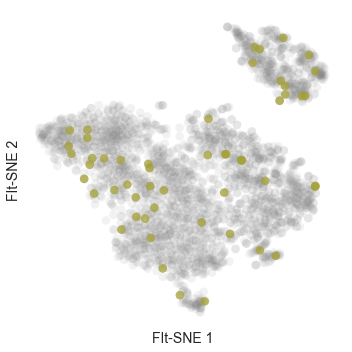

In [168]:
U_FItSNE.plot_barcodes(ranks=[selected_codes[10]])

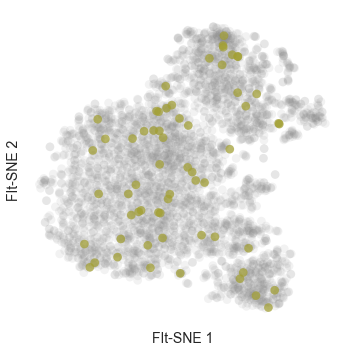

In [169]:
I_FItSNE.plot_barcodes(ranks=[selected_codes[10]])

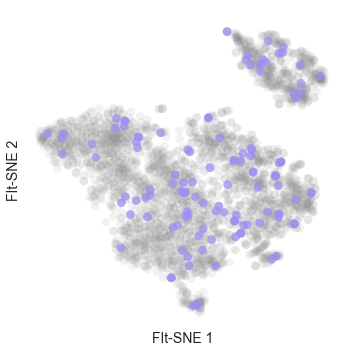

In [170]:
U_FItSNE.plot_barcodes(ranks=[selected_codes[2]])

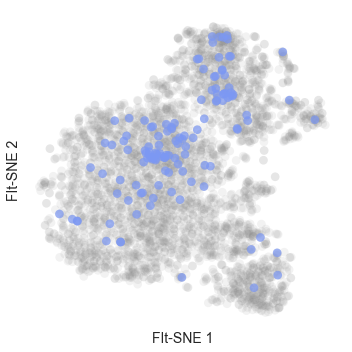

In [171]:
I_FItSNE.plot_barcodes(ranks=[selected_codes[2]])

---
### Feature Selection
Prime t-SNE with variable genes feature selection

In [176]:
U_nvr = U.nvr_select(counts_obj=U)

Start min_conn_k
3 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 3354.0299541950226 seconds
done

Selected 219 variable genes



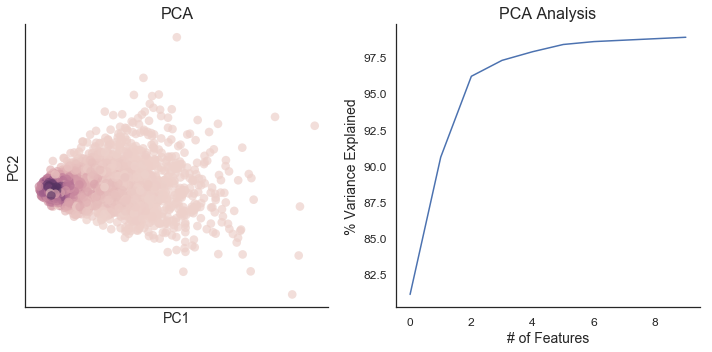

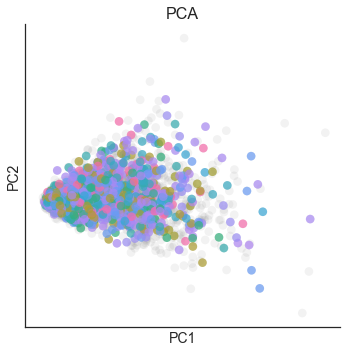

CPU times: user 1.74 s, sys: 146 ms, total: 1.89 s
Wall time: 1.21 s


In [183]:
%%time 
U_nvr_PCA = fcc_PCA(matrix=U_nvr.counts, barcodes=U.barcodes, n_components=10)
U_nvr_PCA.plot()
U_nvr_PCA.plot_barcodes(selected_codes)

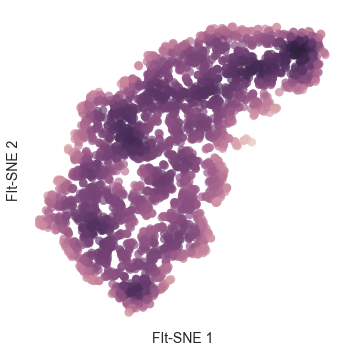

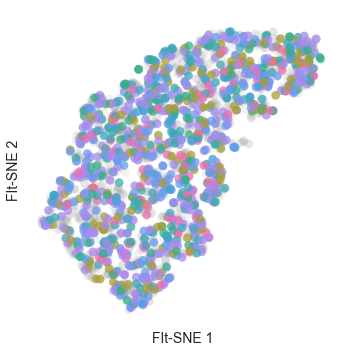

CPU times: user 1.61 s, sys: 386 ms, total: 1.99 s
Wall time: 34.5 s


In [182]:
%%time 
U_nvr_tSNE = fcc_FItSNE(matrix=U_nvr_PCA.results, barcodes=U_nvr_PCA.barcodes, perplexity=30)
U_nvr_tSNE.plot()
U_nvr_tSNE.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

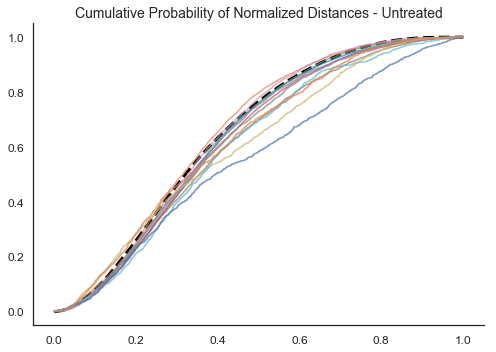

CPU times: user 18.6 s, sys: 637 ms, total: 19.2 s
Wall time: 19.3 s


In [185]:
%%time
pre = U_nvr_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_nvr_tSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

In [186]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_nvr_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_nvr_tSNE.results[np.random.choice(U_FItSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

CPU times: user 3min 31s, sys: 5.3 s, total: 3min 37s
Wall time: 3min 39s


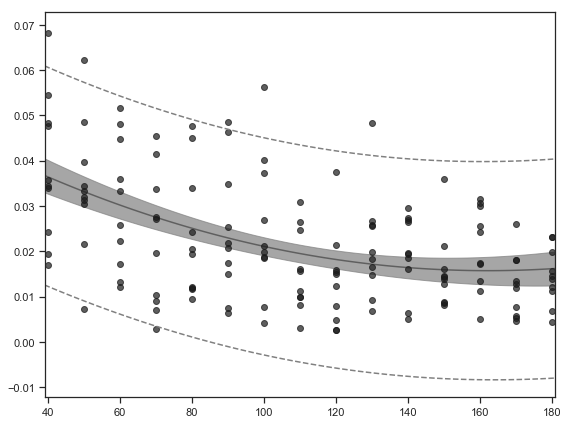

In [187]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)